# How to create and visualize a Landlab Icosphere Grid

*(GE Tucker, CU Boulder, November 2023)*

This notebook demonstrates how to create a spherical `IcosphereGlobalGrid`, and to visualize its geometric elements and related fields.

## About IcosphereGlobal grid

`IcosphereGlobalGrid` represents a spherical surface as an *icosphere*, also known as a *geodesic polyhedron*: a convex polyhedron made of triangular faces. The icosphere allows a relatively even distribution of points across the surface.

The process of creating an `IcosphereGlobalGrid` starts with an *icosahedron* (a 20-sided polyhedron with 12 vertices). The initial icosahedron is then refined by iteratively subdividing each triangle into four smaller triangles. The user of `IcosphereGlobalGrid` specifies how many iterative levels of subdivision are applied, using the parameter `mesh_densification_level`.

An icosphere has the useful characteristic of having a dual geometry. The dual geometry for an icosahedron is a dodecahedron (12-sided polyhedron with 20 vertices). More generally, at any level of subdivision, an icosphere's triangular patches and their vertices have a matching Goldberg Polyhedron, in which each triangle vertex lies within a corresponding pentagonal or (if densification level >0) hexagonal polygon. 

In a Landlab `IcosphereGlobalGrid`, the icosphere comprises triangular *patches* with *nodes* as vertices and *links* as edges. The corresponding Goldberg Polyhedron is composed of pentagonal and hexagonal *cells* with *corners* as vertices and *faces* as the edges of the pentagons and hexagons.

Unlike the various 2D grid types, the nodes and corners in an `IcosphereGlobalGrid` have a $z$ coordinate in addition to their $x$ and $y$ coordinates. The grid also provides the corresponding spherical coordinates $r$, $\phi$, and $\theta$ ($r$ being radial distance from the center of the sphere, $\phi$ the longitude, and $\theta$ the latitude angle measured from zero at the "south" pole (so the equator lies at $\theta = \pi/2$ and the north pole lies at $\theta = \pi$).

## Creating an IcosphereGlobalGrid

The following examples illustrate how to create an `IcosphereGlobalGrid`:

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

import landlab.io.legacy_vtk as vtk
from landlab import IcosphereGlobalGrid

In [ ]:
def plot_ico_grid(vtx_coords, verts_at_line, cmap="Blues", title=None):
    """Plot vertex and line elements of an icosphere grid."""
    fig = plt.figure()
    ax = fig.add_subplot(projection="3d")
    ax.set_title(title)

    val_for_vertex_color = 0.25 * (vtx_coords[:, 0] + 1) + 0.25 * (1 - vtx_coords[:, 1])
    val_for_line_color = 0.25 * (1 - vtx_coords[verts_at_line[:, 0], 1]) + 0.25 * (
        1 + vtx_coords[verts_at_line[:, 0], 0]
    )

    ax.scatter(
        vtx_coords[:, 0],
        vtx_coords[:, 1],
        vtx_coords[:, 2],
        c=val_for_vertex_color,
        cmap=cmap,
    )

    for i in range(grid.number_of_links):
        ax.plot(
            vtx_coords[verts_at_line[i, :], 0],
            vtx_coords[verts_at_line[i, :], 1],
            vtx_coords[verts_at_line[i, :], 2],
            "k",
            alpha=val_for_line_color[i],
        )

    ax.axis("equal")

In [ ]:
# No densification: icosahedron and dodecahedron
grid = IcosphereGlobalGrid()

# Icosahedron: nodes, patches, and links
plot_ico_grid(
    grid.coords_of_node,
    grid.nodes_at_link,
    cmap="Blues",
    title="Icosahedron: nodes, links, and patches",
)

# Dodecahedron: corners, cells, and faces
plot_ico_grid(
    grid.coords_of_corner,
    grid.corners_at_face,
    cmap="Reds",
    title="Dodecahedron: corners, faces, and cells",
)

In [ ]:
# Densification level 1: soccer ball
grid = IcosphereGlobalGrid(radius=1.0, mesh_densification_level=1)

plot_ico_grid(grid.coords_of_corner, grid.corners_at_face, cmap="Reds")

## Adding fields

Fields can be added using the same functions that are used with any other type of grid. The example below creates a grid and adds a node field called `latitude`, to which is assigned the latitude values in degrees. The example also illustrates the use of the `radius` parameter.

In [ ]:
grid = IcosphereGlobalGrid(radius=6.37e6, mesh_densification_level=4)

lat = grid.add_zeros("latitude", at="node")
lat[:] = np.abs(np.degrees(grid.theta_of_node) - 90.0)

fig = plt.figure()
ax = fig.add_subplot(projection="3d")

ax.scatter(
    grid.x_of_node,
    grid.y_of_node,
    grid.z_of_node,
    c=(90.0 - lat),
    cmap="Greens",
    s=5,
)

_ = ax.axis("equal")

## Saving output for external 3D visualization

An effective way to visualize Landlab global grids and fields is to use a 3D visualization package like ParaView. ParaView accepts a variety of input formats; one format that Landlab provides is Legacy VTK. Here's the function signature for the `dump()` function of `landlab.io.legacy_vtk`.

In [ ]:
help(vtk.dump)

The `dump()` function writes a Legacy VTK file for either nodes-links-patches (`at="node"`), or corners-faces-cells (`at="corner"`). By default this function will write all of the node and patch (or corner and face) fields. The fields that are written can be controled by the `include` and `exclude` keywords.

### Output example 1: latitude and longitude values

This example writes output for the grid defined above, along with its field of latitude values. The field is defined on nodes, but it could just as easily have been defined on cells, since there's a one-to-one relationship between nodes and cells for this grid type.

For the sake of illustration, we'll also create a field for longitude values and assign it to patches. This also provides an opportunity to list one of the spherical geometry utility functions, `cartesian_to_spherical()`, which we'll use to calculate the spherical coordinates of the grid *corners*. (In an `IcosphereGlobalGrid`, each *corner* lies within a corresponding triangular *patch*, and their numbering is the same, so it doesn't really matter whether we assign the values to a corner-based field or a patch-based field.)

In [ ]:
from landlab.utils.geometry.spherical import cartesian_to_spherical

# Get spherical coordinates for the corners
corner_r, corner_phi, corner_theta = cartesian_to_spherical(
    grid.x_of_corner, grid.y_of_corner, grid.z_of_corner
)

# Add a patch field for longitude
# lon = grid.add_field("longitude", np.degrees(corner_phi), at="patch")
grid.at_patch["longitude"] = np.degrees(corner_phi)
grid.at_cell["latitude"] = lat

In [ ]:
with open("latlon_example-patches.vtk", "w") as fp:
    vtk.dump(grid, fp, at="node")

with open("latlon_example-cells.vtk", "w") as fp:
    vtk.dump(grid, fp, at="corner")

Here's what these two files look like when rendered in ParaView:

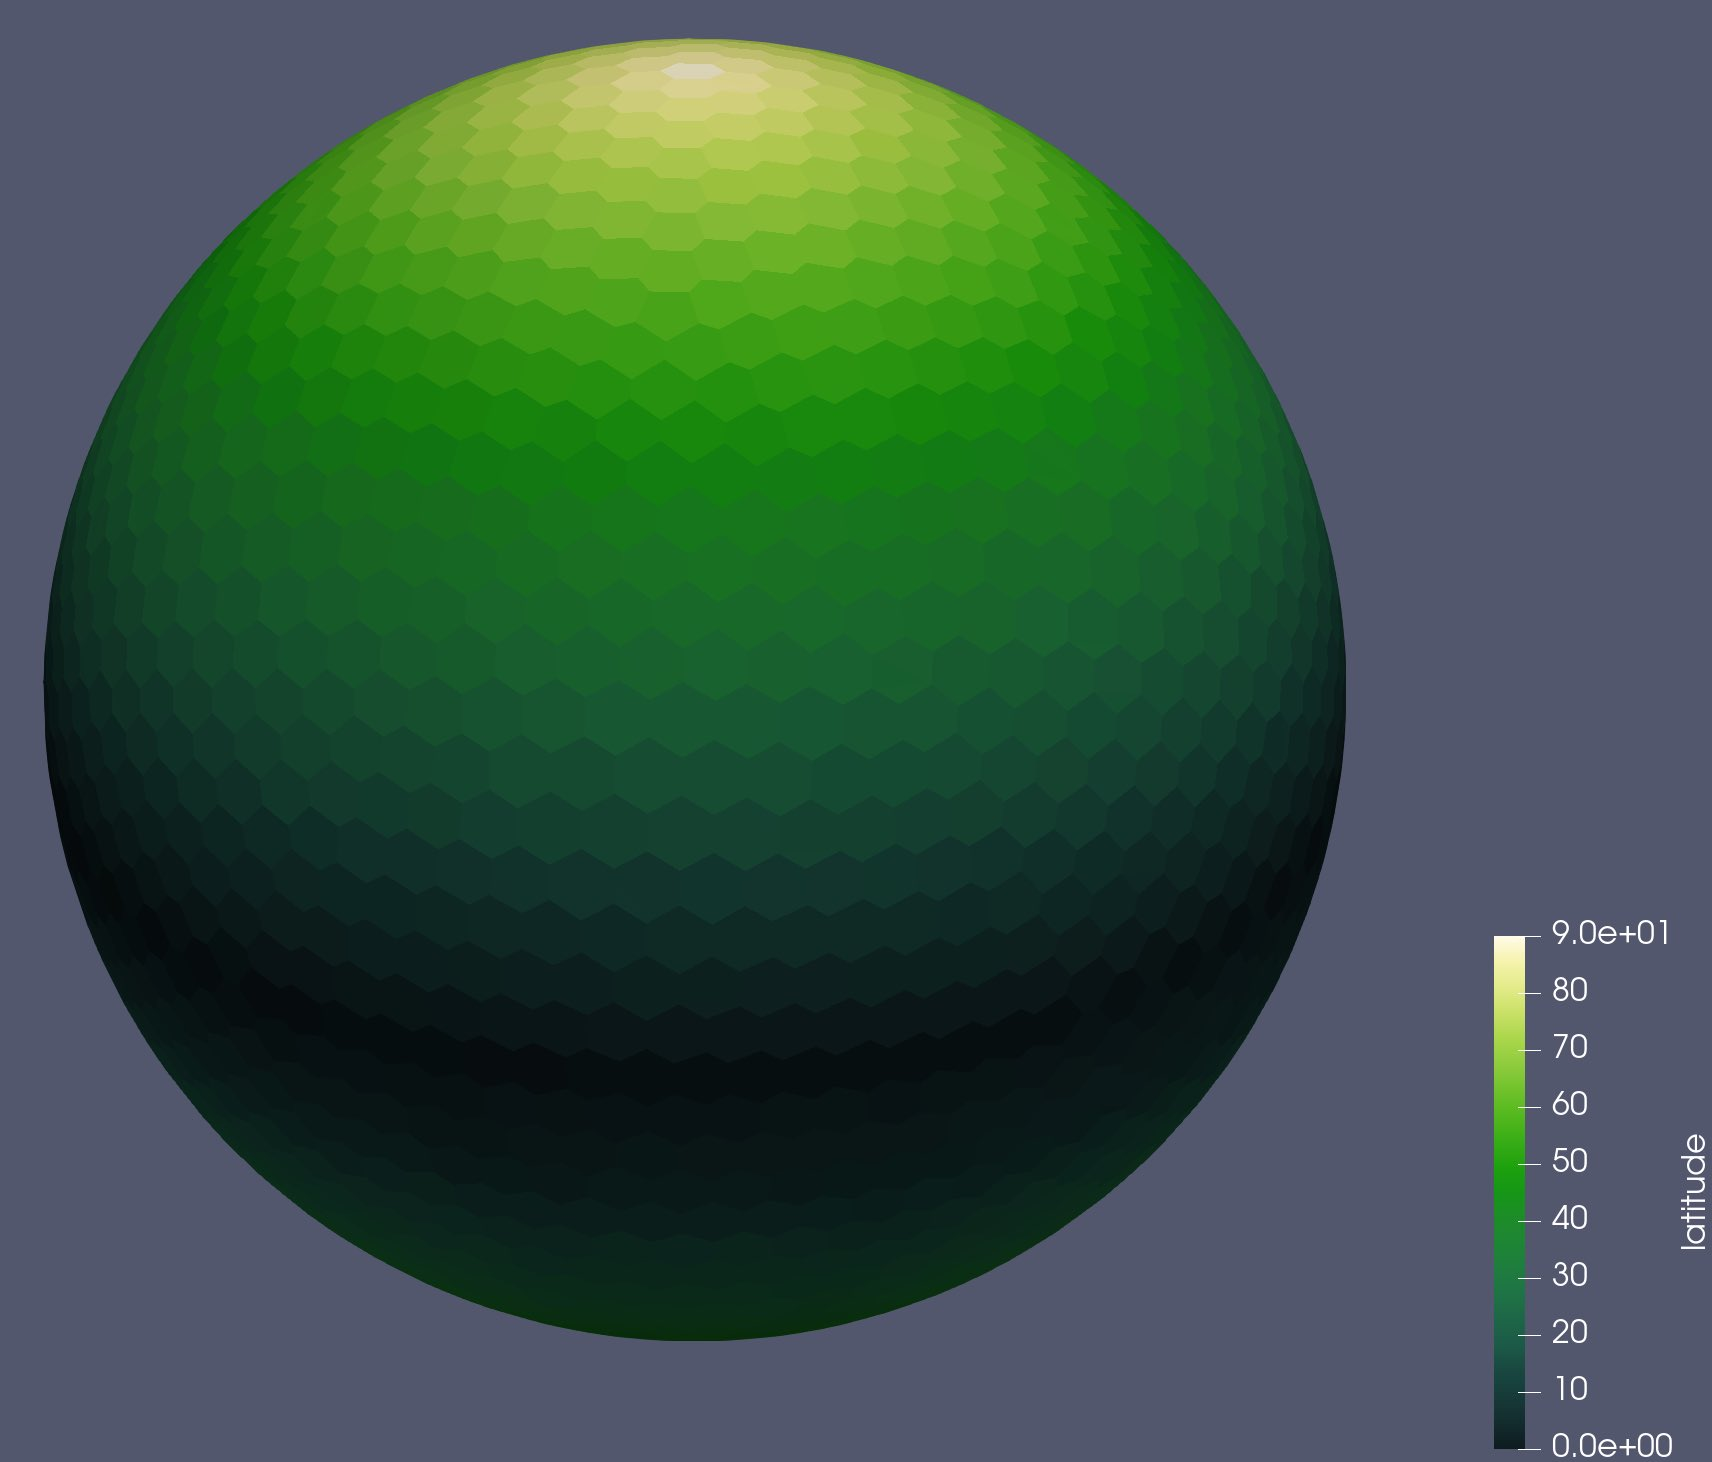


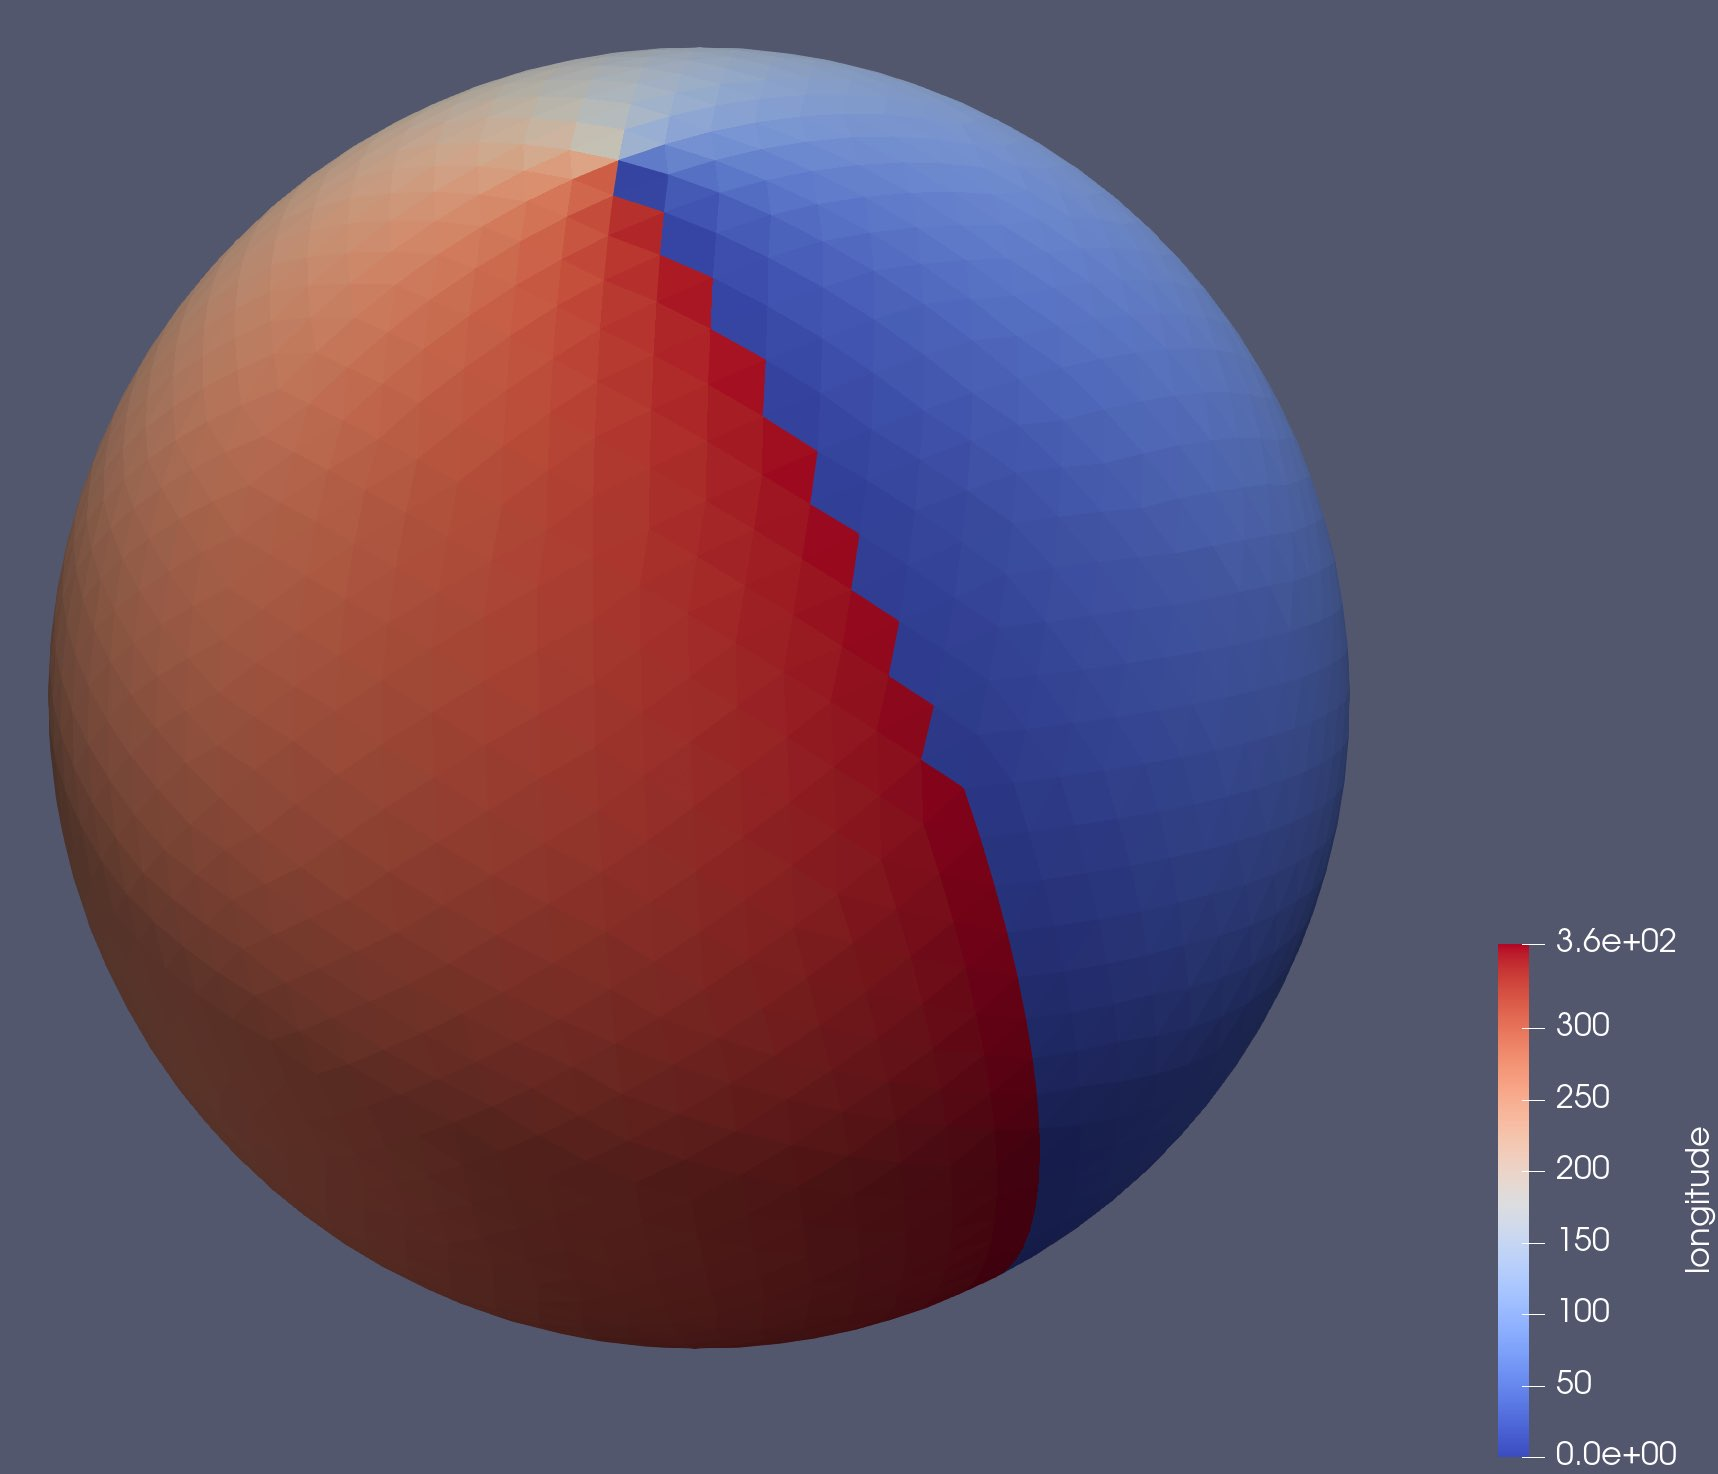



### Output example 2: soccer ball

Just for fun, here's an example in which we use a field to assign different values to pentagonal versus hexagonal cells, so that the rendering of cells looks like a soccer ball.

In [ ]:
grid = IcosphereGlobalGrid(mesh_densification_level=1)

is_hexagon = np.amin(grid.corners_at_cell, axis=1) > -1

cell_code = grid.add_zeros("cell_code", at="cell")
cell_code[is_hexagon] = 1.0

with open("soccer_ball-patches.vtk", "w") as fp:
    vtk.dump(grid, fp, at="node")
with open("soccer_ball-cells.vtk", "w") as fp:
    vtk.dump(grid, fp, at="corner")

Paraview rendering (note that apparent triangle subdivisions are a ParaView thing):

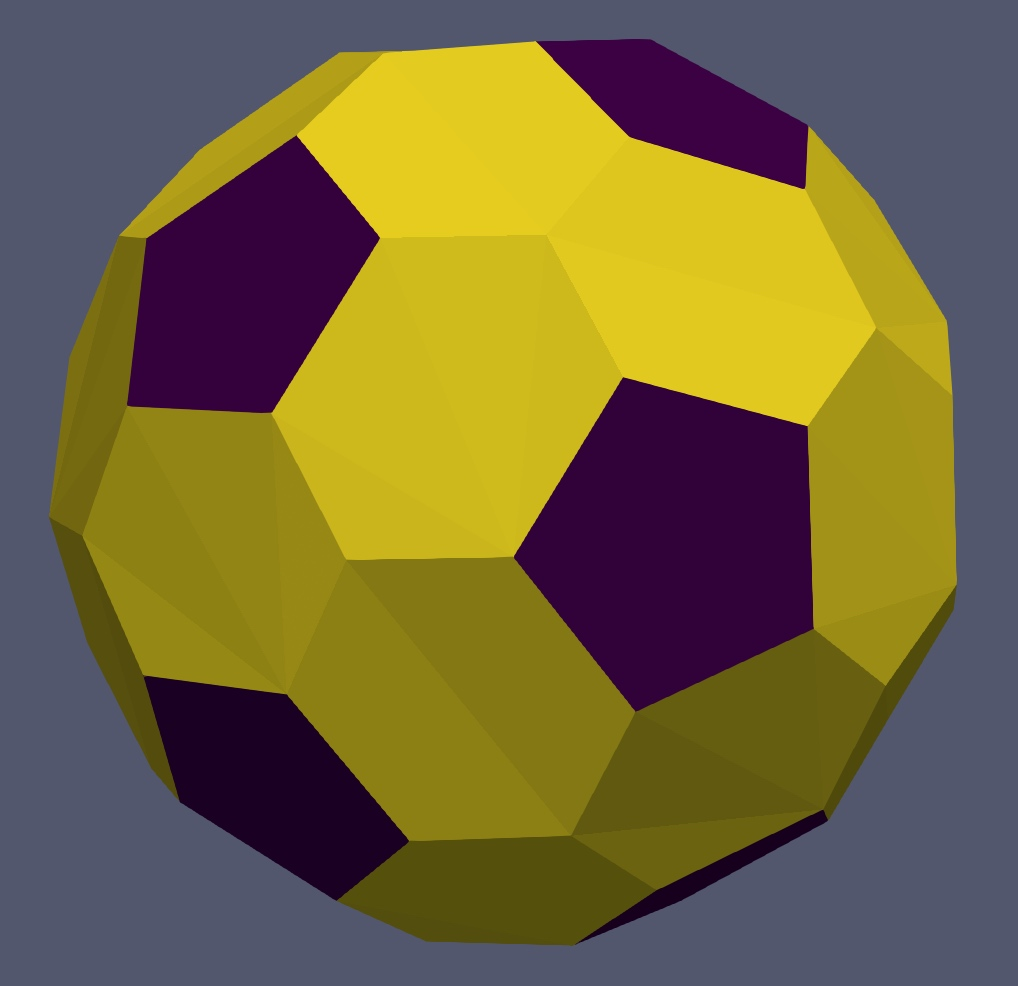

Displaying both dual geometries illustrates how the two map onto one another. In this image, *cells* and their *faces* are outlined in red; their vertices are *corners*. Triangular *patches* are shown in solid teal; their edges are *links* and their vertices are *nodes*.

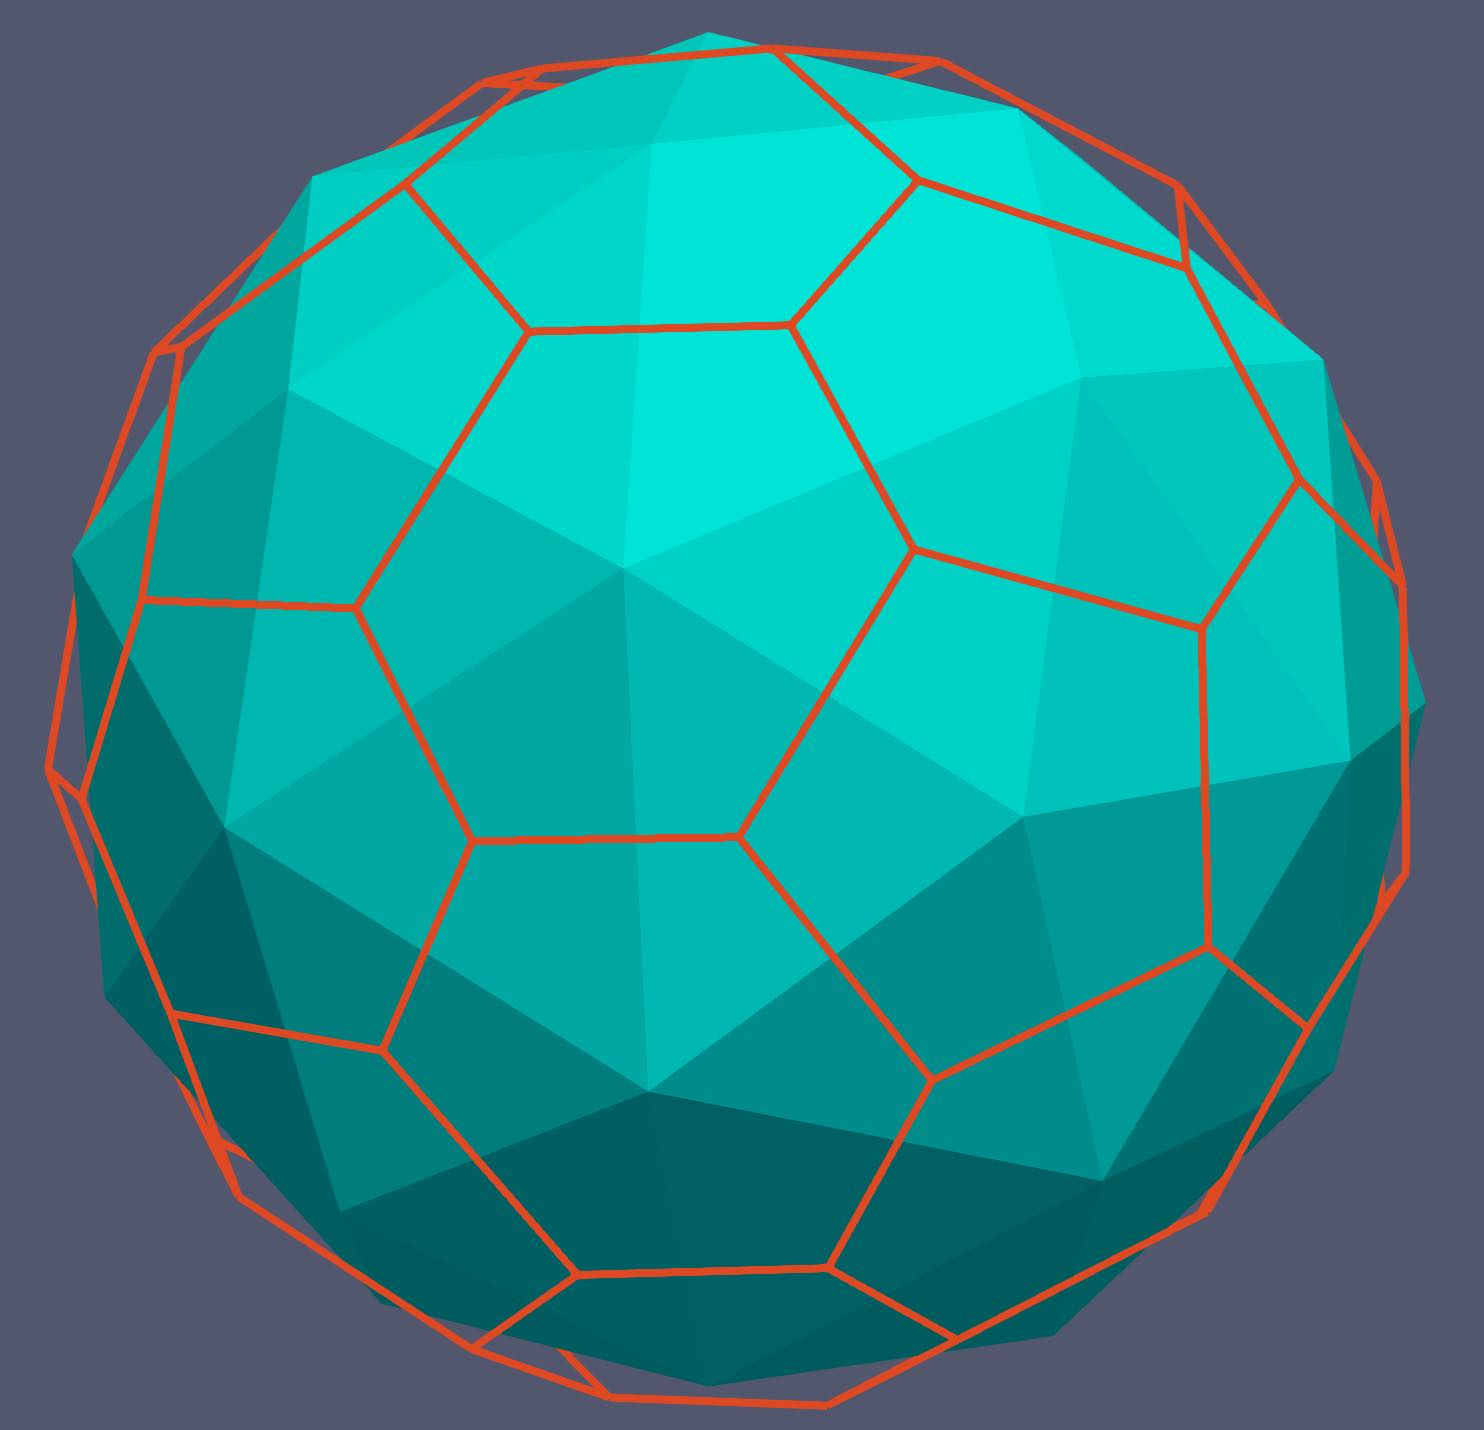

